<a href="https://colab.research.google.com/github/sungshin98/kci/blob/main/kci_klue_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


wav 디렉토리에서 .txt 파일의 개수를 찾음

In [2]:
'''
import os

directory = '/content/drive/MyDrive/wav'
total_files = 0

# 디렉토리 순회
for root, dirs, files in os.walk(directory):
    # txt 파일 개수 계산
    txt_files = [file for file in files if file.endswith('.txt')]
    total_files += len(txt_files)

print("총 txt 파일 개수:", total_files)
'''

'\nimport os\n\ndirectory = \'/content/drive/MyDrive/wav\'\ntotal_files = 0\n\n# 디렉토리 순회\nfor root, dirs, files in os.walk(directory):\n    # txt 파일 개수 계산\n    txt_files = [file for file in files if file.endswith(\'.txt\')]\n    total_files += len(txt_files)\n\nprint("총 txt 파일 개수:", total_files)\n'

In [3]:
!pip install transformers
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 55.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 10.2 MB/s eta 0:00:00


In [4]:
import os
import pandas as pd
import numpy as np
import re
from tqdm import tqdm
import urllib.request
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, \
                            roc_auc_score, confusion_matrix, classification_report, \
                            matthews_corrcoef, cohen_kappa_score, log_loss

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [5]:
MODEL_NAME = "klue/bert-base"
model = TFBertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3, from_pt=True)
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
  print("GPU 작동 중")
  mirrored_strategy = tf.distribute.MirroredStrategy()
else:
  print("GPU 미작동 중")

GPU 작동 중


annotation 내의 파일들과 wav 디렉토리 내의 txt 파일들을 매칭하여
새로운 csv 파일 만듦 (스크립트와 감정 매칭)


In [7]:
'''
import os
import pandas as pd

# 데이터를 담을 빈 리스트 생성
data = []

# 디렉토리 순회
directory = '/content/drive/MyDrive/wav'
eval_directory = '/content/drive/MyDrive/annotation'
for session in range(1, 41):
    session_dir = os.path.join(directory, f"Session{session:02d}")
    eval_file = os.path.join(eval_directory, f"Sess{session:02d}_eval.csv")
    if os.path.exists(session_dir) and os.path.exists(eval_file):
        eval_data = pd.read_csv(eval_file)
        for filename in os.listdir(session_dir):
            if filename.endswith(".txt"):
                txt_file = os.path.join(session_dir, filename)
                with open(txt_file, 'r' , encoding='cp949') as f:
                    segment_id = os.path.splitext(filename)[0]
                    sentiment = f.read().strip()
                    try:
                        total_evaluation = eval_data[eval_data['Segment ID'] == segment_id]['Total Evaluation'].values[0]
                    except IndexError:
                        total_evaluation = "Unknown"
                    data.append([sentiment, total_evaluation])

# DataFrame으로 변환하고 CSV 파일로 저장
df = pd.DataFrame(data, columns=['Sentiment', 'Total Evaluation'])
df.to_csv('/content/drive/MyDrive/wav/sentiment_evaluation.csv', index=False)
'''

'\nimport os\nimport pandas as pd\n\n# 데이터를 담을 빈 리스트 생성\ndata = []\n\n# 디렉토리 순회\ndirectory = \'/content/drive/MyDrive/wav\'\neval_directory = \'/content/drive/MyDrive/annotation\'\nfor session in range(1, 41):\n    session_dir = os.path.join(directory, f"Session{session:02d}")\n    eval_file = os.path.join(eval_directory, f"Sess{session:02d}_eval.csv")\n    if os.path.exists(session_dir) and os.path.exists(eval_file):\n        eval_data = pd.read_csv(eval_file)\n        for filename in os.listdir(session_dir):\n            if filename.endswith(".txt"):\n                txt_file = os.path.join(session_dir, filename)\n                with open(txt_file, \'r\' , encoding=\'cp949\') as f:\n                    segment_id = os.path.splitext(filename)[0]\n                    sentiment = f.read().strip()\n                    try:\n                        total_evaluation = eval_data[eval_data[\'Segment ID\'] == segment_id][\'Total Evaluation\'].values[0]\n                    except IndexError:

In [8]:
df = pd.read_csv('/content/drive/MyDrive/wav/sentiment_evaluation.csv')

In [9]:
df["Total Evaluation"].value_counts()

0    11235
1     1539
2      233
3      210
4      120
5       61
6       43
Name: Total Evaluation, dtype: int64

In [10]:
df[df['Total Evaluation'] == "Unknwon"] #결측치

,Unnamed: 0,Sentiment,Total Evaluation


In [11]:
# 합칠 값들과 합칠 기준값 설정
values_to_merge = ["happy;neutral", "angry;neutral", "neutral;sad", "surprise;neutral", "neutral;disqust", "happy;surprise", "angry;disqust",
                   "happy;fear", "angry;neutral;disqust", "happy;sad", "neutral;disqust;sad", "angry;neutral;disqust;fear;sad",
                   "happy;surprise;neutral", "happy;angry;neutral", "Unknown", "happy;neutral;disqust", "happy;neutral;fear", "neutral;fear"]

# 합칠 값들을 하나의 값으로 합치기
for value in values_to_merge:
    merged_value = value.split(';')[0]  # 합칠 값들 중 첫 번째 값을 선택하여 합칠 값으로 사용
    df['Total Evaluation'] = df['Total Evaluation'].replace(value, merged_value)

df=df[df['Total Evaluation']!='Unknown']  # 결측치 제거

print(df['Total Evaluation'].value_counts())


0    11235
1     1539
2      233
3      210
4      120
5       61
6       43
Name: Total Evaluation, dtype: int64


In [12]:
# 감정을 숫자로 변환
df['Total Evaluation'] = df['Total Evaluation'].replace(['neutral', 'happy', 'angry', 'surprise', 'sad', 'disqust', 'fear'] ,[0, 1, 2, 3, 4, 5, 6])

# 영어와 특수문자 제외한 문자 제거 함수 정의 (\n 과 같은 문제 제거)
def remove_special_characters(text):
    processed_text = re.sub(r"[^가-힣.]", " ", text)
    return processed_text

# 'Sentiment' 열에 함수 적용
df['Sentiment'] = df['Sentiment'].apply(remove_special_characters)

df.head()

,Unnamed: 0,Sentiment,Total Evaluation
0,0,어 가영이는 통금 같은 건 없었어,0
1,1,내가 익산에서 있다 보니까 그런 것도 있지만 어 어머니가 그거에 대해서 ...,0
2,2,그 이해 안 되는 다른 행동을 한 적은 있었어,0
3,3,어 그니까 어머니도 되게 외부 일이 되게 많으신데 밤에 막 회식하거나 일이 많으시...,0
4,4,그런 게 딱 정해져 있으셔서 되게 늦으면 많이 혼났던 기억이 있어.,0


In [13]:
X_data = df['Sentiment']
y_data = df['Total Evaluation']

df.info() #Non=Null임을 확인
df[df['Sentiment'].duplicated()]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13441 entries, 0 to 13440
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        13441 non-null  int64 
 1   Sentiment         13441 non-null  object
 2   Total Evaluation  13441 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 420.0+ KB


,Unnamed: 0,Sentiment,Total Evaluation


중복되는 값이 있는지 확인하고 제거

In [14]:
'''
DATASET_PREP_FILE = '/content/drive/MyDrive/wav/sentiment_evaluation.csv'
# 중복 데이터 제거
df.drop_duplicates(subset = ['Sentiment'], inplace = True)
df.to_csv(DATASET_PREP_FILE) # 구글 드라이브 내 data 폴더에 저장
'''

"\nDATASET_PREP_FILE = '/content/drive/MyDrive/wav/sentiment_evaluation.csv'\n# 중복 데이터 제거\ndf.drop_duplicates(subset = ['Sentiment'], inplace = True)\ndf.to_csv(DATASET_PREP_FILE) # 구글 드라이브 내 data 폴더에 저장\n"

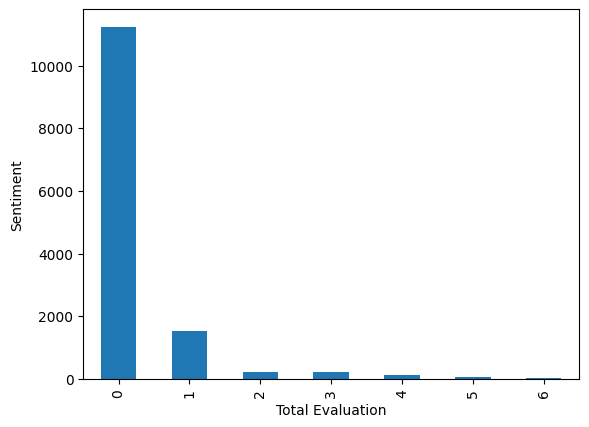

In [15]:
df['Total Evaluation'].value_counts().plot(kind = 'bar')
plt.xlabel("Total Evaluation")
plt.ylabel("Sentiment")
plt.show()

In [24]:
lengths=[len(row) for row in df['Sentiment']]
print(np.mean(lengths))
print(np.std(lengths))
print(np.var(lengths))

37.02209657019567
30.105009823876426
906.3116164956961


In [27]:
TEST_SIZE = 0.2 # Train: Test = 8 :2 분리
RANDOM_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data,
                                                    test_size = TEST_SIZE,
                                                    random_state = RANDOM_STATE,
                                                    stratify = y_data)

print(f"훈련 입력 데이터 개수: {len(X_train)}")
print(f"테스트 입력 데이터 개수: {len(X_test)}")

# 훈련 데이터 라벨별 비율
print(y_train.value_counts(normalize = True))

# 테스트 데이터 라벨별 비율
print(y_test.value_counts(normalize = True))

훈련 입력 데이터 개수: 10752
테스트 입력 데이터 개수: 2689
0    0.835844
1    0.114490
2    0.017299
3    0.015625
4    0.008929
5    0.004557
6    0.003255
Name: Total Evaluation, dtype: float64
0    0.835999
1    0.114541
2    0.017479
3    0.015619
4    0.008925
5    0.004463
6    0.002975
Name: Total Evaluation, dtype: float64


In [28]:
# 입력 데이터(문장) 길이 제한
MAX_SEQ_LEN = 70

def convert_data(X_data, y_data):
    # BERT 입력으로 들어가는 token, mask, segment, target 저장용 리스트
    tokens, masks, segments, targets = [], [], [], []

    for X, y in tqdm(zip(X_data, y_data)):
        # token: 입력 문장 토큰화
        token = tokenizer.encode(X, truncation = True, padding = 'max_length', max_length = MAX_SEQ_LEN)

        # Mask: 토큰화한 문장 내 패딩이 아닌 경우 1, 패딩인 경우 0으로 초기화
        num_zeros = token.count(0)
        mask = [1] * (MAX_SEQ_LEN - num_zeros) + [0] * num_zeros

        # segment: 문장 전후관계 구분: 오직 한 문장이므로 모두 0으로 초기화
        segment = [0]*MAX_SEQ_LEN

        tokens.append(token)
        masks.append(mask)
        segments.append(segment)
        targets.append(y)

    # numpy array로 저장
    tokens = np.array(tokens)
    masks = np.array(masks)
    segments = np.array(segments)
    targets = np.array(targets)

    return [tokens, masks, segments], targets

In [29]:
# train 데이터를 Bert의 Input 타입에 맞게 변환
train_x, train_y = convert_data(X_train, y_train)

# test 데이터를 Bert의 Input 타입에 맞게 변환
test_x, test_y = convert_data(X_test, y_test)

10752it [00:02, 4420.08it/s]
2689it [00:00, 4726.75it/s]


In [30]:
# token, mask, segment 입력 정의
token_inputs = tf.keras.layers.Input((MAX_SEQ_LEN,), dtype = tf.int32, name = 'input_word_ids')
mask_inputs = tf.keras.layers.Input((MAX_SEQ_LEN,), dtype = tf.int32, name = 'input_masks')
segment_inputs = tf.keras.layers.Input((MAX_SEQ_LEN,), dtype = tf.int32, name = 'input_segment')
bert_outputs = model([token_inputs, mask_inputs, segment_inputs])

In [37]:
bert_output = bert_outputs[0]

DROPOUT_RATE = 0.5
NUM_CLASS = 7
dropout = tf.keras.layers.Dropout(DROPOUT_RATE)(bert_output)
# Multi-class classification 문제이므로 activation function은 softmax로 설정
sentiment_layer = tf.keras.layers.Dense(NUM_CLASS, activation='softmax', kernel_initializer = tf.keras.initializers.TruncatedNormal(stddev=0.02))(dropout)
sentiment_model = tf.keras.Model([token_inputs, mask_inputs, segment_inputs], sentiment_layer)

# 옵티마이저 Rectified Adam 하이퍼파리미터 조정
OPTIMIZER_NAME = 'RAdam'
LEARNING_RATE = 1e-5
TOTAL_STEPS = 10000
MIN_LR = 1e-5
WARMUP_PROPORTION = 0.1
EPSILON = 1e-8
CLIPNORM = 1.0
optimizer = tfa.optimizers.RectifiedAdam(learning_rate = LEARNING_RATE,
                                          total_steps = TOTAL_STEPS,
                                          warmup_proportion = WARMUP_PROPORTION,
                                          min_lr = MIN_LR,
                                          epsilon = EPSILON,
                                          clipnorm = CLIPNORM)


# 감정분류 모델 컴파일
sentiment_model.compile(optimizer = optimizer,
                        loss = tf.keras.losses.SparseCategoricalCrossentropy(),
                        metrics = ['accuracy'])

MIN_DELTA = 1e-3
PATIENCE = 5

early_stopping = EarlyStopping(
    monitor = "val_accuracy",
    min_delta = MIN_DELTA,
    patience = PATIENCE)

# 최고 성능의 모델 파일을 저장할 이름과 경로 설정
BEST_MODEL_NAME = 'best_model.h5'
model_checkpoint = ModelCheckpoint(
    filepath = BEST_MODEL_NAME,
    monitor = "val_loss",
    mode = "min",
    save_best_only = True, # 성능 향상 시에만 모델 저장
    verbose = 1
)

callbacks = [early_stopping, model_checkpoint]

In [39]:
EPOCHS = 100
BATCH_SZIE = 32

sentiment_model.fit(train_x, train_y,
                    epochs = EPOCHS,
                    shuffle = True,
                    batch_size = BATCH_SZIE,
                    validation_data = (test_x, test_y),
                    callbacks = callbacks
                    )

Epoch 1/100
336/336 [==============================] - ETA: 0s - loss: 1.8030 - accuracy: 0.2167
Epoch 1: val_loss improved from inf to 1.72796, saving model to best_model.h5
336/336 [==============================] - 217s 572ms/step - loss: 1.8030 - accuracy: 0.2167 - val_loss: 1.7280 - val_accuracy: 0.0175
Epoch 2/100
336/336 [==============================] - ETA: 0s - loss: 1.7375 - accuracy: 0.3228
Epoch 2: val_loss improved from 1.72796 to 1.62544, saving model to best_model.h5
336/336 [==============================] - 189s 562ms/step - loss: 1.7375 - accuracy: 0.3228 - val_loss: 1.6254 - val_accuracy: 0.8360
Epoch 3/100
336/336 [==============================] - ETA: 0s - loss: 1.6207 - accuracy: 0.4791
Epoch 3: val_loss improved from 1.62544 to 1.46732, saving model to best_model.h5
336/336 [==============================] - 190s 565ms/step - loss: 1.6207 - accuracy: 0.4791 - val_loss: 1.4673 - val_accuracy: 0.8360
Epoch 4/100
336/336 [==============================] - ETA: 0s

In [40]:
# 최고 성능의 모델 불러오기
sentiment_model_best = tf.keras.models.load_model(BEST_MODEL_NAME,
                                                  custom_objects={'TFBertForSequenceClassification': TFBertForSequenceClassification})

# 모델이 예측한 라벨 도출
predicted_value = sentiment_model_best.predict(test_x)
predicted_label = np.argmax(predicted_value, axis = 1)

# Classification Report 저장
CL_REPORT_FILE = "cl_report.csv"

cl_report = classification_report(test_y, predicted_label, output_dict = True)
cl_report_df = pd.DataFrame(cl_report).transpose()
cl_report_df = cl_report_df.round(3)
cl_report_df.to_csv(CL_REPORT_FILE)
print(cl_report_df)

85/85 [==============================] - 81s 162ms/step
              precision  recall  f1-score   support
0                 0.836   1.000     0.911  2248.000
1                 0.000   0.000     0.000   308.000
2                 0.000   0.000     0.000    47.000
3                 0.000   0.000     0.000    42.000
4                 0.000   0.000     0.000    24.000
5                 0.000   0.000     0.000    12.000
6                 0.000   0.000     0.000     8.000
accuracy          0.836   0.836     0.836     0.836
macro avg         0.119   0.143     0.130  2689.000
weighted avg      0.699   0.836     0.761  2689.000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
